In [1]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 1.1 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 21.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.9 MB/s eta 0:00:00


In [2]:
!pip install numpy>=2.0 pandas>=2.2 scikit-learn>=1.5 scipy>=1.12 matplotlib>=3.8 seaborn>=0.12 imbalanced-learn>=0.12 xgboost>=1.7 boto3 mlflow

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyopenssl 23.2.0 requires cryptography!=40.0.0,!=40.0.1,<42,>=38.0.0, but you have cryptography 46.0.3 which is incompatible.
numba 0.57.1 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 which is incompatible.


In [3]:
## S3
import os
import boto3
import pandas as pd
from io import BytesIO

BUCKET = os.environ.get("MINIO_BUCKET", "data-bucket")
ENDPOINT = "http://minio:9000"   # dentro do docker compose

ACCESS_KEY = os.environ["AWS_ACCESS_KEY_ID"]
SECRET_KEY = os.environ["AWS_SECRET_ACCESS_KEY"]

# Cliente S3/MinIO
s3 = boto3.client(
    "s3",
    endpoint_url=ENDPOINT,
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY,
    region_name="us-east-1"
)

# Caminho do arquivo enviado pelo ingest
object_key = "raw/diabetes_dataset.csv"

# Download para memória
obj = s3.get_object(Bucket=BUCKET, Key=object_key)
data = obj["Body"].read()

df = pd.read_csv(BytesIO(data))

df.head()

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N


In [4]:
!pip install imblearn

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [6]:
# remover colunaas ID e no_patin

df.drop(['ID', 'No_Pation'], axis=1, inplace=True)
# transformando coluna GENDER pra F=0 e M=1
df['Gender'] = df['Gender'].map({'F':0, 'M':1, 'f':0})

In [7]:
# tipos e nulos
print(df.info())
print("\nNulos por coluna:\n", df.isnull().sum())

# duplicados
print("Duplicated rows:", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gender  1000 non-null   int64  
 1   AGE     1000 non-null   int64  
 2   Urea    1000 non-null   float64
 3   Cr      1000 non-null   int64  
 4   HbA1c   1000 non-null   float64
 5   Chol    1000 non-null   float64
 6   TG      1000 non-null   float64
 7   HDL     1000 non-null   float64
 8   LDL     1000 non-null   float64
 9   VLDL    1000 non-null   float64
 10  BMI     1000 non-null   float64
 11  CLASS   1000 non-null   object 
dtypes: float64(8), int64(3), object(1)
memory usage: 93.9+ KB
None

Nulos por coluna:
 Gender    0
AGE       0
Urea      0
Cr        0
HbA1c     0
Chol      0
TG        0
HDL       0
LDL       0
VLDL      0
BMI       0
CLASS     0
dtype: int64
Duplicated rows: 170


### analise exploratoria

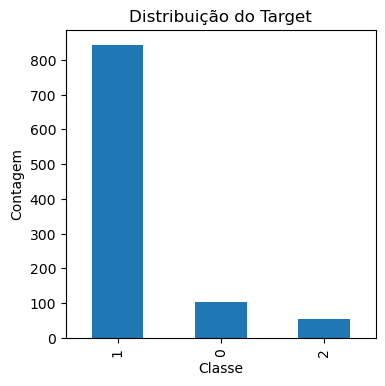

In [8]:
df['target'] = df['CLASS'].map({'Y':1, 'N':0, 'P':2, 'N ':0, 'Y ':1})

plt.figure(figsize=(4,4))
df['target'].value_counts().plot(kind='bar')
plt.title("Distribuição do Target")
plt.xlabel("Classe")
plt.ylabel("Contagem")
plt.show()

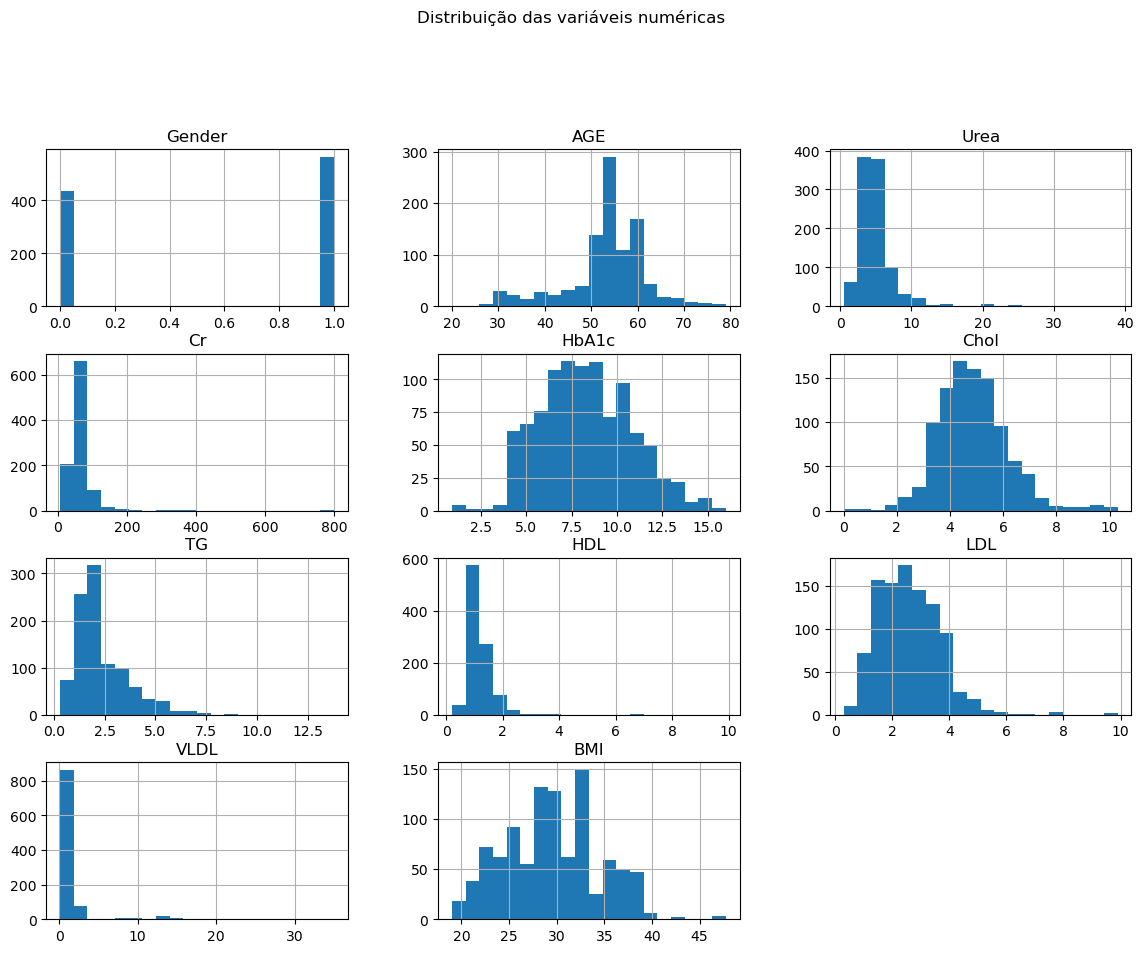

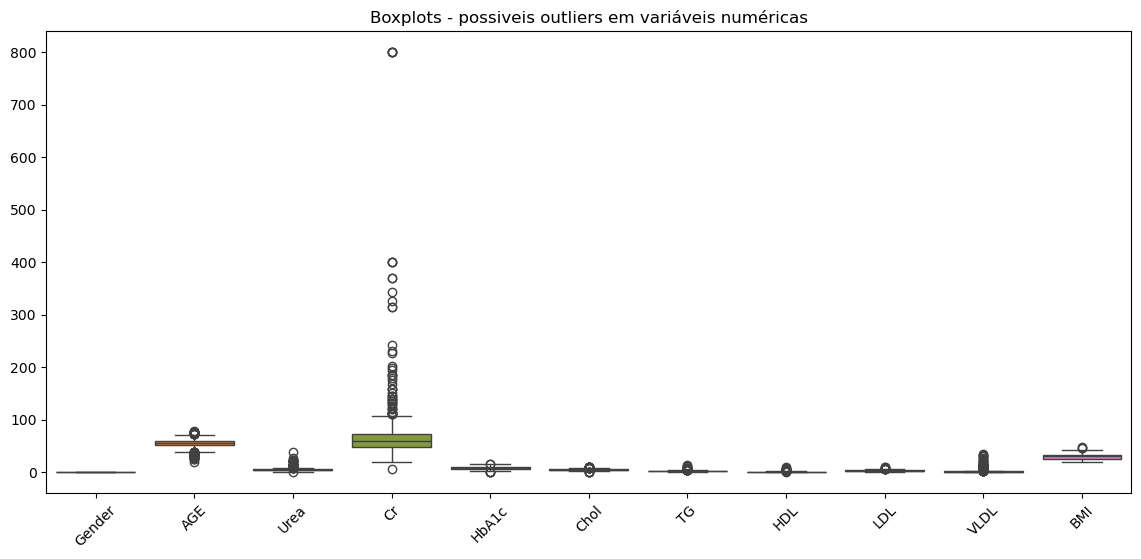

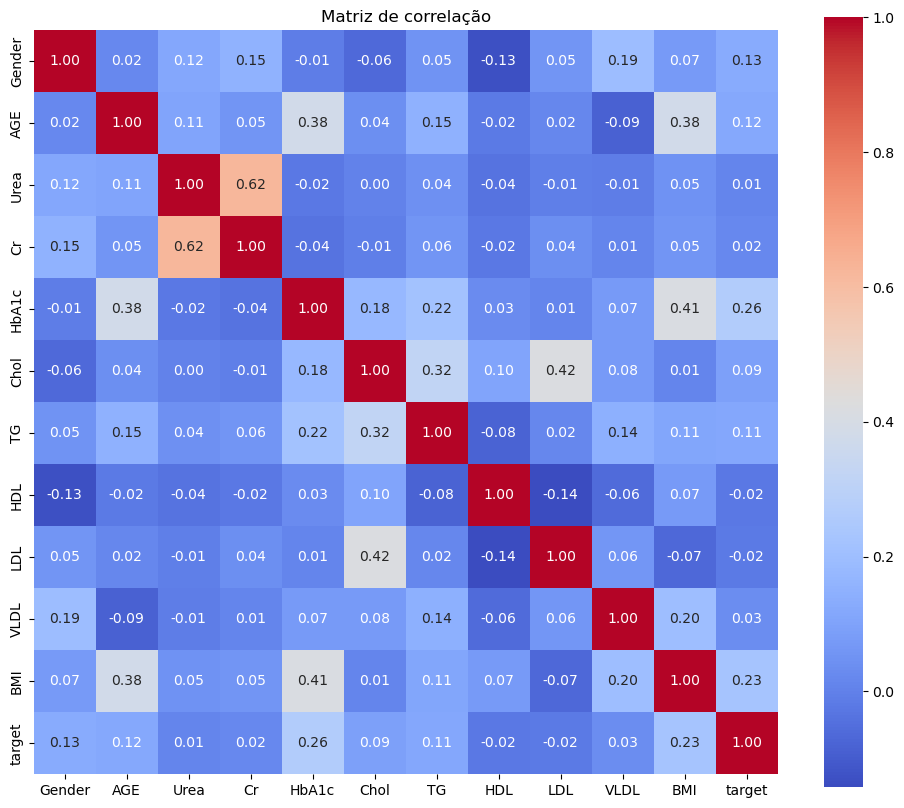

In [9]:
num_cols = df.select_dtypes(include=['float64','int64']).columns.drop('target', errors='ignore')

df[num_cols].hist(bins=20, figsize=(14,10))
plt.suptitle("Distribuição das variáveis numéricas", y=1.02)
plt.show()

plt.figure(figsize=(14,6))
sns.boxplot(data=df[num_cols])
plt.xticks(rotation=45)
plt.title("Boxplots - possiveis outliers em variáveis numéricas")
plt.show()


plt.figure(figsize=(12,10))
corr = df[num_cols.tolist() + ['target']].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de correlação")
plt.show()

# sns.pairplot(df[num_cols.tolist() + ['target']], hue='target')
# plt.show()

## Random forest

== Avaliação em TEST ==
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        31
           1       0.99      0.99      0.99       253
           2       1.00      0.88      0.93        16

    accuracy                           0.99       300
   macro avg       0.98      0.96      0.96       300
weighted avg       0.99      0.99      0.99       300

ROC AUC (TEST): 0.9977615654378698


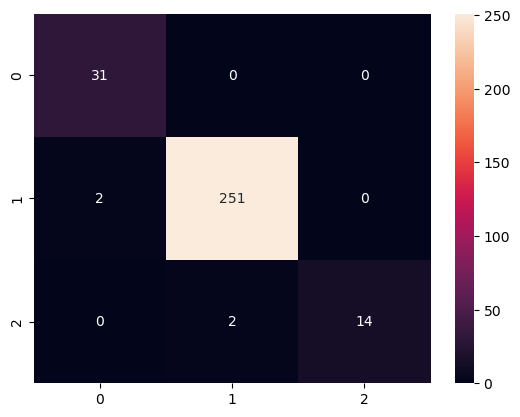

In [10]:
modelo = df.copy()
#removendo coluna CLASS
modelo = modelo.drop(columns=['CLASS'])
X = modelo.drop(columns=['target'])
y = modelo['target']

#divisao treino/teste 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


pipe_rf = ImbPipeline(steps=[
    # ('scaler', RobustScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(
        random_state=42,
        class_weight=None
    ))
])

pipe_rf.fit(X_train, y_train)

pred_val = pipe_rf.predict(X_test)
proba_val = pipe_rf.predict_proba(X_test)

print("== Avaliação em TEST ==")
print(classification_report(y_test, pred_val))

# ROC multiclass
print("ROC AUC (TEST):", roc_auc_score(
    y_test, proba_val, multi_class='ovr', average='weighted'
))

# confusion matrix
cm = confusion_matrix(y_test, pred_val)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

Resultados:

accuracy -> mean: 0.9670 | std: 0.0212 | 95% CI: [0.9333, 1.0000] | n=50
precision -> mean: 0.9718 | std: 0.0180 | 95% CI: [0.9410, 1.0000] | n=50
recall   -> mean: 0.9670 | std: 0.0212 | 95% CI: [0.9333, 1.0000] | n=50
f1       -> mean: 0.9669 | std: 0.0210 | 95% CI: [0.9291, 1.0000] | n=50


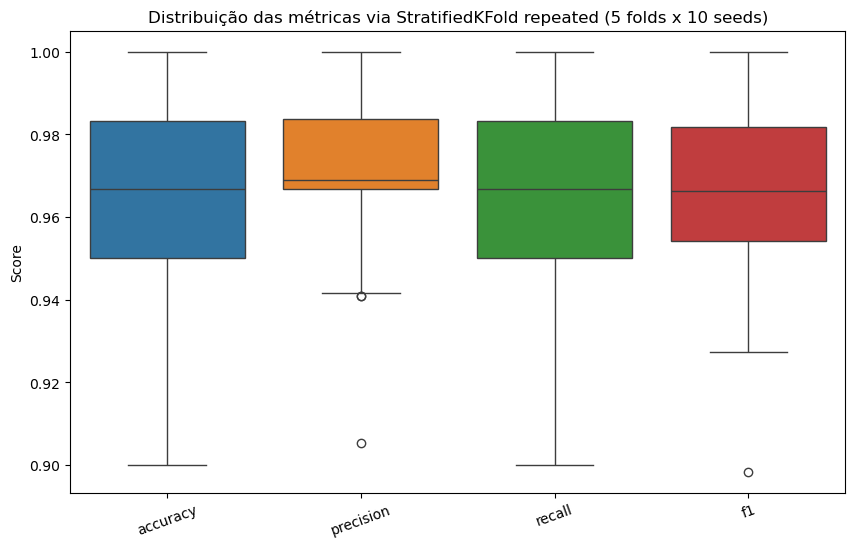

In [11]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_validate

scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(
        precision_score,
        average='weighted',
        zero_division=0
    ),
    'recall': make_scorer(
        recall_score,
        average='weighted',
        zero_division=0
    ),
    'f1': make_scorer(
        f1_score,
        average='weighted',
        zero_division=0
    )
}

# parâmetros da validação repetida
n_splits = 5
n_repeats = 10
seeds = list(range(n_repeats))
all_scores = {k: [] for k in scoring.keys()}

# validação cruzada repetida
for seed in seeds:
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    res = cross_validate(pipe_rf, X_test, y_test, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    for metric in scoring.keys():
        all_scores[metric].extend(res[f'test_{metric}'])

# agregação
results = []
for metric, scores in all_scores.items():
    arr = np.array(scores)
    mean = arr.mean()
    std = arr.std(ddof=1)
    lo, hi = np.percentile(arr, [2.5, 97.5])
    results.append((metric, mean, std, lo, hi, len(arr)))

print("Resultados:\n")
for metric, mean, std, lo, hi, n in results:
    print(f"{metric:8s} -> mean: {mean:.4f} | std: {std:.4f} | 95% CI: [{lo:.4f}, {hi:.4f}] | n={n}")

# boxplot
plt.figure(figsize=(10,6))
sns.boxplot(data=pd.DataFrame({m: all_scores[m] for m in all_scores.keys()}))
plt.title(f"Distribuição das métricas via StratifiedKFold repeated ({n_splits} folds x {n_repeats} seeds)")
plt.ylabel("Score")
plt.xticks(rotation=20)
plt.show()

## XGBoost

Resultados XGBoost via StratifiedKFold repeated:

accuracy -> mean: 0.9894 | std: 0.0064 | 95% CI: [0.9800, 1.0000] | n=50
precision -> mean: 0.9900 | std: 0.0060 | 95% CI: [0.9806, 1.0000] | n=50
recall   -> mean: 0.9894 | std: 0.0064 | 95% CI: [0.9800, 1.0000] | n=50
f1       -> mean: 0.9895 | std: 0.0064 | 95% CI: [0.9792, 1.0000] | n=50


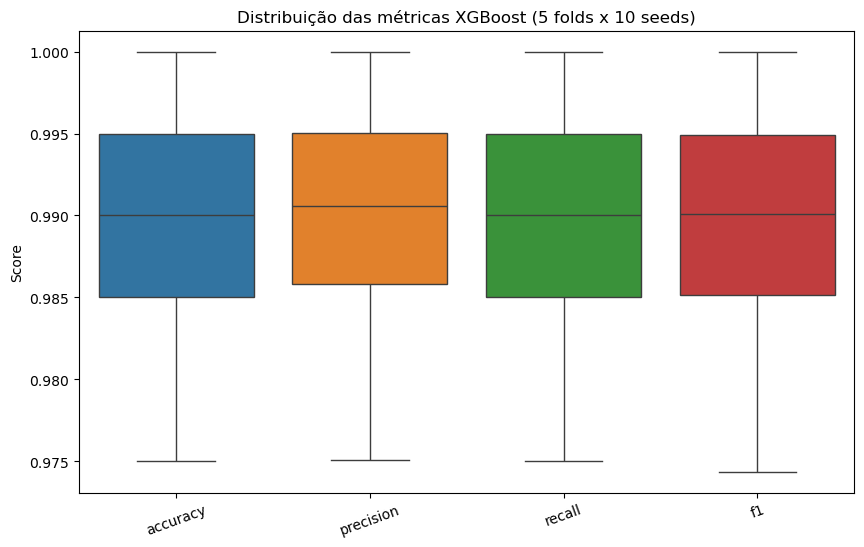


== CLASSIFICATION REPORT (TEST) ==
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        31
           1       0.99      1.00      0.99       253
           2       1.00      0.94      0.97        16

    accuracy                           0.99       300
   macro avg       0.99      0.97      0.98       300
weighted avg       0.99      0.99      0.99       300



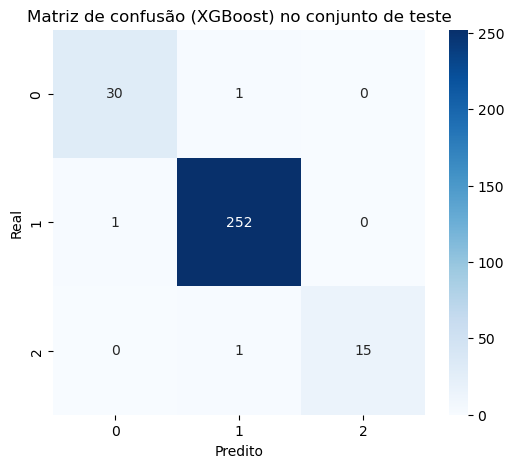

In [12]:
from xgboost import XGBClassifier

# preparando X e y
modelo_xgb = df.copy()
modelo_xgb = modelo_xgb.drop(columns=['CLASS'])
X_xgb = modelo_xgb.drop(columns=['target'])
y_xgb = modelo_xgb['target']

# split 70/30 estratificado para matriz de confusão e relatório final
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb,
    test_size=0.3,
    random_state=42,
    stratify=y_xgb
)

# pipeline XGB + SMOTE
pipe_xgb = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('clf', XGBClassifier(
        random_state=42,
        objective='multi:softprob',
        num_class=3,
        eval_metric='mlogloss'
    ))
])

# métricas multiclasse (sem ROC)
scoring_xgb = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0)
}

# parâmetros da validação repetida
n_splits = 5
n_repeats = 10
seeds = list(range(n_repeats))

all_scores_xgb = {k: [] for k in scoring_xgb.keys()}

# loop de validação cruzada repetida
for seed in seeds:
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    res = cross_validate(
        pipe_xgb, X_xgb, y_xgb,
        cv=cv,
        scoring=scoring_xgb,
        n_jobs=-1,
        return_train_score=False
    )
    for metric in scoring_xgb.keys():
        all_scores_xgb[metric].extend(res[f'test_{metric}'])

# agregação estatística das métricas
results_xgb = []
for metric, scores in all_scores_xgb.items():
    arr = np.array(scores)
    mean = arr.mean()
    std = arr.std(ddof=1)
    lo, hi = np.percentile(arr, [2.5, 97.5])
    results_xgb.append((metric, mean, std, lo, hi, len(arr)))

print("Resultados XGBoost via StratifiedKFold repeated:\n")
for metric, mean, std, lo, hi, n in results_xgb:
    print(f"{metric:8s} -> mean: {mean:.4f} | std: {std:.4f} | 95% CI: [{lo:.4f}, {hi:.4f}] | n={n}")

# boxplot das métricas
plt.figure(figsize=(10,6))
sns.boxplot(data=pd.DataFrame({m: all_scores_xgb[m] for m in all_scores_xgb.keys()}))
plt.title(f"Distribuição das métricas XGBoost ({n_splits} folds x {n_repeats} seeds)")
plt.ylabel("Score")
plt.xticks(rotation=20)
plt.show()

# treinamento final para matriz de confusão
pipe_xgb.fit(X_train_xgb, y_train_xgb)

pred_test_xgb = pipe_xgb.predict(X_test_xgb)

print("\n== CLASSIFICATION REPORT (TEST) ==")
print(classification_report(y_test_xgb, pred_test_xgb))

cm_xgb = confusion_matrix(y_test_xgb, pred_test_xgb)

plt.figure(figsize=(6,5))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusão (XGBoost) no conjunto de teste")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

## Mandando pro MLFLow

2025/11/30 18:55:52 INFO mlflow.tracking.fluent: Experiment with name 'experimento_xgboost' does not exist. Creating a new experiment.


🏃 View run seed_0 at: http://mlflow:5000/#/experiments/1/runs/40a5fad5be6241f8a469356d6c69f573
🧪 View experiment at: http://mlflow:5000/#/experiments/1
🏃 View run seed_1 at: http://mlflow:5000/#/experiments/1/runs/d9698896d472485c8fa794137374fa64
🧪 View experiment at: http://mlflow:5000/#/experiments/1
🏃 View run seed_2 at: http://mlflow:5000/#/experiments/1/runs/e242d4caffdf4a6ba6e92d6b7b824824
🧪 View experiment at: http://mlflow:5000/#/experiments/1
🏃 View run seed_3 at: http://mlflow:5000/#/experiments/1/runs/ca610f06e17b430a900105e90f27b379
🧪 View experiment at: http://mlflow:5000/#/experiments/1
🏃 View run seed_4 at: http://mlflow:5000/#/experiments/1/runs/39ac3f9eb2ef46249c45151e67cbb6ee
🧪 View experiment at: http://mlflow:5000/#/experiments/1
🏃 View run seed_5 at: http://mlflow:5000/#/experiments/1/runs/2606f9dad0204d599ca1df7943b18a0a
🧪 View experiment at: http://mlflow:5000/#/experiments/1
🏃 View run seed_6 at: http://mlflow:5000/#/experiments/1/runs/5da7013cb0e243068753feacd8

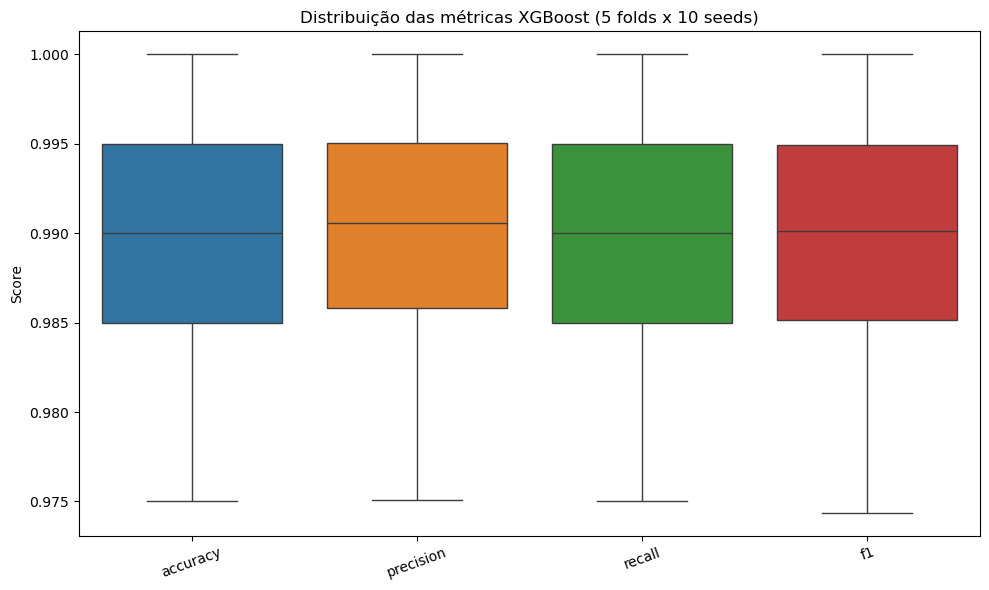


== CLASSIFICATION REPORT (TEST) ==
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        31
           1       0.99      1.00      0.99       253
           2       1.00      0.94      0.97        16

    accuracy                           0.99       300
   macro avg       0.99      0.97      0.98       300
weighted avg       0.99      0.99      0.99       300



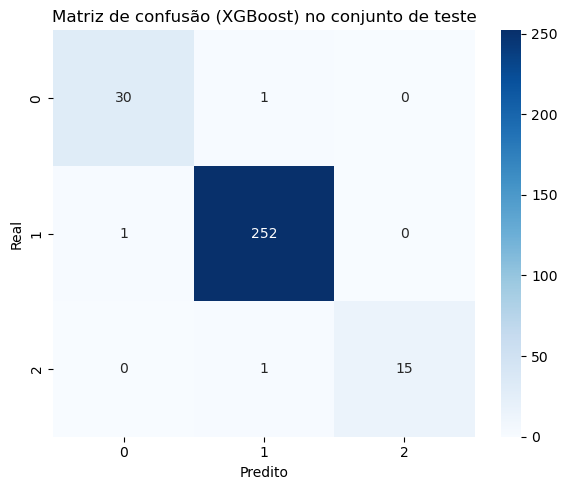

2025/11/30 18:56:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/30 18:56:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run xgboost_experimento_global at: http://mlflow:5000/#/experiments/1/runs/37f103f10f9741b68b8b95fda6b766ee
🧪 View experiment at: http://mlflow:5000/#/experiments/1
Experimento XGBoost registrado no MLflow.


In [13]:
from xgboost import XGBClassifier
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("http://mlflow:5000")
mlflow.set_experiment("experimento_xgboost")

with mlflow.start_run(run_name="xgboost_experimento_global"):

    modelo_xgb = df.copy()
    modelo_xgb = modelo_xgb.drop(columns=['CLASS'])
    X_xgb = modelo_xgb.drop(columns=['target'])
    y_xgb = modelo_xgb['target']

    X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
        X_xgb, y_xgb,
        test_size=0.3,
        random_state=42,
        stratify=y_xgb
    )

    pipe_xgb = ImbPipeline(steps=[
        ('smote', SMOTE(random_state=42)),
        ('clf', XGBClassifier(
            random_state=42,
            objective='multi:softprob',
            num_class=3,
            eval_metric='mlogloss'
        ))
    ])

    scoring_xgb = {
        'accuracy': 'accuracy',
        'precision': make_scorer(precision_score, average='weighted', zero_division=0),
        'recall': make_scorer(recall_score, average='weighted', zero_division=0),
        'f1': make_scorer(f1_score, average='weighted', zero_division=0)
    }

    n_splits = 5
    n_repeats = 10
    seeds = list(range(n_repeats))

    # para estatísticas globais
    all_scores_xgb = {k: [] for k in scoring_xgb.keys()}

    for seed in seeds:

        # run filha para esta seed
        with mlflow.start_run(run_name=f"seed_{seed}", nested=True):

            cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
            res = cross_validate(
                pipe_xgb, X_xgb, y_xgb,
                cv=cv,
                scoring=scoring_xgb,
                n_jobs=-1,
                return_train_score=False
            )

            for metric in scoring_xgb.keys():
                fold_scores = res[f"test_{metric}"]

                # log de cada fold
                for i, score in enumerate(fold_scores):
                    mlflow.log_metric(f"{metric}_fold_{i}", float(score))

                # média da seed para referência
                mlflow.log_metric(f"{metric}_mean_seed", float(np.mean(fold_scores)))

                # acumula para estatísticas globais
                all_scores_xgb[metric].extend(fold_scores)

            # marcar tag para organização no MLflow
            mlflow.set_tag("seed", seed)

    # estatísticas globais
    results_xgb = []
    for metric, scores in all_scores_xgb.items():
        arr = np.array(scores)
        mean = arr.mean()
        std = arr.std(ddof=1)
        lo, hi = np.percentile(arr, [2.5, 97.5])
        n = len(scores)

        mlflow.log_metric(f"{metric}_global_mean", float(mean))
        mlflow.log_metric(f"{metric}_global_std", float(std))
        mlflow.log_metric(f"{metric}_global_ci_low", float(lo))
        mlflow.log_metric(f"{metric}_global_ci_high", float(hi))

        results_xgb.append((metric, mean, std, lo, hi, n))

    print("Resultados XGBoost via StratifiedKFold repeated:\n")
    for metric, mean, std, lo, hi, n in results_xgb:
        print(f"{metric:8s} -> mean: {mean:.4f} | std: {std:.4f} | 95% CI: [{lo:.4f}, {hi:.4f}] | n={n}")

    # boxplot
    plt.figure(figsize=(10,6))
    df_box = pd.DataFrame({m: all_scores_xgb[m] for m in all_scores_xgb.keys()})
    sns.boxplot(data=df_box)
    plt.title(f"Distribuição das métricas XGBoost ({n_splits} folds x {n_repeats} seeds)")
    plt.ylabel("Score")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.savefig("boxplot_metricas_xgb.png")
    mlflow.log_artifact("boxplot_metricas_xgb.png")
    plt.show()

    # salvar CSV global
    df_results_csv = pd.DataFrame(results_xgb, columns=["metric", "mean", "std", "ci_low", "ci_high", "n"])
    df_results_csv.to_csv("resultados_xgb.csv", index=False)
    mlflow.log_artifact("resultados_xgb.csv")

    # treinamento final
    pipe_xgb.fit(X_train_xgb, y_train_xgb)
    pred_test_xgb = pipe_xgb.predict(X_test_xgb)

    report = classification_report(y_test_xgb, pred_test_xgb)
    print("\n== CLASSIFICATION REPORT (TEST) ==")
    print(report)

    with open("classification_report_xgb.txt", "w") as f:
        f.write(report)
    mlflow.log_artifact("classification_report_xgb.txt")

    # matriz de confusão
    cm_xgb = confusion_matrix(y_test_xgb, pred_test_xgb)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues")
    plt.title("Matriz de confusão (XGBoost) no conjunto de teste")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.savefig("confusion_matrix_xgb.png")
    mlflow.log_artifact("confusion_matrix_xgb.png")
    plt.show()

    # log do modelo final
    mlflow.sklearn.log_model(pipe_xgb, "modelo_xgb")

print("Experimento XGBoost registrado no MLflow.")
